# 데이터 로드

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 138kB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 450kB 48.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# 필요 프레임워크 및 라이브러리 준비
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 사전에 정제+정규화된 훈련용 통합 데이터 로드
total_data = pd.read_table('total(movie+shopping+game)_data.txt')

In [ ]:
# 통합 데이터 확인
print(len(total_data))
print(total_data[:3])

489016
                                            document  label
0                                        이유식 냄비로 좋아요      1
1                                       한글화가 없어서짜징난다      0
2  에휴 존나 뚝 뚝 끊키는대뭘게임을하라고 무슨 핑은좋은대 게임만들어가면 뚝뚝 끊키고 ...      0


# 토큰화

In [ ]:
# 불용어 정의 (한국어 조사, 접속사 등) 18
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 훈련데이터에 형태소 분석기를 사용하여 토큰화를 하면서 불용어 제거
okt = Okt()
X_total = []
for sentence in total_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_total.append(temp_X)

In [ ]:
print(len(X_total))
print(X_total[:3])

[['이유식', '냄비', '로', '좋다'], ['한글화', '없다', '짜다', '징', '난', '다'], ['휴', '존나', '뚝', '뚝', '끊다', '키', '대', '뭘', '게', '이다', '무슨', '핑', '좋다', '게임', '만', '들어가다', '뚝뚝', '끊다', '키', '고', '걸다', '괜찮다', '또', '총', '쏘다', '뚝뚝', '끊다', '키', '고', '해결', '법', '없다', '뭘', '게', '이다']]


# 정수 인코딩

In [ ]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 데이터를 정수로 변환
# 일단 단어 집합을 만들자
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_total)
 # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성한다.
 # 단어 빈도수가 높은순으로 낮은 정수 인덱스 부여

In [ ]:
print(len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.word_counts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# 등장 빈도수가 낮은 데이터를 처리해보자
# 특정 횟수 이하 단어의 비중이 몇인지 체크
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 85794
등장 빈도가 2번 이하인 희귀 단어의 수: 50413
단어 집합에서 희귀 단어의 비율: 58.76051938363989
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.016628619931301


In [ ]:
# 전체 단어 개수 중 빈도수 12이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 35382


In [ ]:
# 단어집합을 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_total)
X_total = tokenizer.texts_to_sequences(X_total)

In [ ]:
print(X_total[:3])

[[2732, 4498, 15, 2], [710, 7, 264, 2506, 241, 12], [950, 425, 5133, 5133, 2075, 355, 200, 609, 51, 9, 253, 1508, 2, 8, 19, 267, 3338, 2075, 355, 30, 672, 79, 132, 558, 780, 3338, 2075, 355, 30, 982, 1310, 7, 609, 51, 9]]


In [ ]:
y_total = np.array(total_data['label'])

# 빈 샘플(empty samples)제거

In [ ]:
# 각 샘플의 길이가 0인 샘플들의 인덱스 확인
drop_total = [index for index, sentence in enumerate(X_total) if len(sentence) < 1]
print(drop_total)

[276, 307, 547, 796, 1120, 1373, 2343, 2986, 4228, 5097, 5109, 6781, 12156, 12380, 13388, 13531, 14632, 14928, 15550, 16844, 17257, 17852, 19313, 21575, 21628, 21964, 23852, 27170, 27545, 28289, 28523, 29113, 29211, 29382, 30843, 31175, 32099, 33805, 34424, 35084, 35415, 36367, 36630, 37159, 37436, 38539, 38550, 38985, 39823, 39859, 40432, 42212, 42361, 42896, 44802, 45031, 48040, 48880, 49252, 50511, 50533, 50921, 50946, 52285, 52921, 53875, 54153, 58382, 58594, 58710, 58715, 59266, 59343, 62103, 62772, 63518, 64722, 64813, 65123, 68701, 68847, 69519, 69850, 69862, 69886, 70307, 71458, 71509, 73025, 75950, 76777, 78879, 79566, 79994, 81020, 82187, 87152, 87519, 88014, 89307, 89351, 90202, 90440, 91204, 91964, 92389, 92988, 93739, 93891, 94613, 95566, 96166, 97801, 98887, 99571, 99679, 99823, 101599, 101937, 101993, 102131, 102544, 102761, 103957, 105816, 106600, 107573, 108803, 113450, 113468, 114738, 114766, 114939, 114946, 115384, 117534, 118058, 118472, 118548, 119034, 119292, 1202

In [ ]:
# 빈 샘플들을 제거
X_total = np.delete(X_total, drop_total, axis=0)
y_total = np.delete(y_total, drop_total, axis=0)
print(len(X_total))
print(len(y_total))

488447
488447


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 11.978009896672516


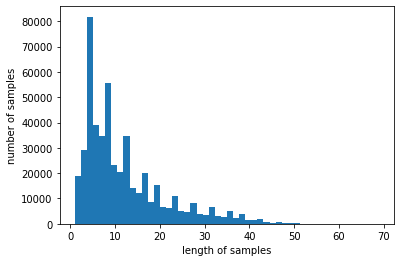

In [ ]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰는 작업
# 전체 데이터에서 가장 길이가 긴 리뷰와, 전체의 길이분포를 알아보자
print('리뷰의 최대 길이 :',max(len(l) for l in X_total))
print('리뷰의 평균 길이 :',sum(map(len, X_total))/len(X_total))
plt.hist([len(s) for s in X_total], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 최적의 길이를 찾기 위해, 전체 샘플중 길이가 max_len 이하인 샘플의 비율을 확인하는 함수 생성
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
# 30 이하 비율 체크
max_len = 30
below_threshold_len(max_len, X_total)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 93.6846781738858


In [ ]:
# 짧은 데이터는 0을 채우고, 30을 넘는 긴 데이터는 손실됨
X_total = pad_sequences(X_total, maxlen = max_len)

# LSTM/GRU/BiLSTM 모델 훈련

In [ ]:
# 필요한 프레임워크 및 라이브러리 임포트
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 임베딩 벡터의 차원은 100으로, 리뷰분류를 위해 LSTM 사용
# 왜 100인지는 모름
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, 100))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1, activation='sigmoid'))

In [ ]:
model_GRU = Sequential()
model_GRU.add(Embedding(vocab_size, 100))
model_GRU.add(GRU(128))
model_GRU.add(Dense(1, activation='sigmoid'))

In [ ]:
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(vocab_size, 100))
model_BiLSTM.add(Bidirectional(LSTM(128)))
model_BiLSTM.add(Dense(1, activation='sigmoid'))

In [ ]:
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
# model check point를 사용하여 검증 데이터의 정확도가 이전보다 좋아질 경우만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_LSTM = ModelCheckpoint('RNN_LSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mc_GRU = ModelCheckpoint('RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
mc_BiLSTM = ModelCheckpoint('RNN_BiLSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# 필요한 매트릭 선언, AUC-ROC, F1-Score, AUC-PR 에 필요한 지표 모두 체크
import tensorflow as tf

ROCauc = tf.keras.metrics.AUC(curve="ROC") # auc_1
PRauc = tf.keras.metrics.AUC(curve="PR") # auc_2
RECALL = tf.keras.metrics.Recall()
PRECISION = tf.keras.metrics.Precision()
TP = tf.keras.metrics.TruePositives()
TN = tf.keras.metrics.TrueNegatives()
FP = tf.keras.metrics.FalsePositives()
FN = tf.keras.metrics.FalseNegatives()

In [ ]:
# LSTM모델 훈련
model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_LSTM.fit(X_total, y_total, epochs=15, callbacks=[es, mc_LSTM], batch_size=100, validation_split=0.2)

Epoch 1/15
3908/3908 [==============================] - 87s 21ms/step - loss: 0.3671 - acc: 0.8387 - auc_2: 0.9167 - auc_3: 0.9139 - recall_1: 0.8319 - precision_1: 0.8431 - true_positives_1: 162328.0000 - true_negatives_1: 165404.0000 - false_positives_1: 30215.0000 - false_negatives_1: 32810.0000 - val_loss: 0.3348 - val_acc: 0.8568 - val_auc_2: 0.9314 - val_auc_3: 0.9295 - val_recall_1: 0.8436 - val_precision_1: 0.8667 - val_true_positives_1: 41240.0000 - val_true_negatives_1: 42457.0000 - val_false_positives_1: 6345.0000 - val_false_negatives_1: 7648.0000

Epoch 00001: val_acc improved from -inf to 0.85676, saving model to RNN_LSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5
Epoch 2/15
3908/3908 [==============================] - 85s 22ms/step - loss: 0.3201 - acc: 0.8646 - auc_2: 0.9371 - auc_3: 0.9347 - recall_1: 0.8601 - precision_1: 0.8677 - true_positives_1: 167830.0000 - true_negatives_1: 170037.0000 - false_positives_1: 25582.0000 - false_negatives_1: 27308.0000 - val_los

In [ ]:
# GRU모델 훈련
model_GRU.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_GRU.fit(X_total, y_total, epochs=15, callbacks=[es, mc_GRU], batch_size=100, validation_split=0.2)

Epoch 1/15
3908/3908 [==============================] - 92s 22ms/step - loss: 0.3650 - acc: 0.8400 - auc_2: 0.9211 - auc_3: 0.9188 - recall_1: 0.8410 - precision_1: 0.8466 - true_positives_1: 205223.0000 - true_negatives_1: 207236.0000 - false_positives_1: 37185.0000 - false_negatives_1: 38803.0000 - val_loss: 0.3360 - val_acc: 0.8556 - val_auc_2: 0.9307 - val_auc_3: 0.9290 - val_recall_1: 0.8428 - val_precision_1: 0.8652 - val_true_positives_1: 41203.0000 - val_true_negatives_1: 42380.0000 - val_false_positives_1: 6422.0000 - val_false_negatives_1: 7685.0000

Epoch 00001: val_acc improved from -inf to 0.85559, saving model to RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5
Epoch 2/15
3908/3908 [==============================] - 83s 21ms/step - loss: 0.3180 - acc: 0.8663 - auc_2: 0.9379 - auc_3: 0.9357 - recall_1: 0.8621 - precision_1: 0.8691 - true_positives_1: 168223.0000 - true_negatives_1: 170293.0000 - false_positives_1: 25326.0000 - false_negatives_1: 26915.0000 - val_loss

In [ ]:
# BiLSTM모델 훈련
model_BiLSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_BiLSTM.fit(X_total, y_total, epochs=15, callbacks=[es, mc_BiLSTM], batch_size=100, validation_split=0.2)

Epoch 1/15
3908/3908 [==============================] - 110s 26ms/step - loss: 0.3679 - acc: 0.8379 - auc_2: 0.9191 - auc_3: 0.9166 - recall_1: 0.8365 - precision_1: 0.8459 - true_positives_1: 204131.0000 - true_negatives_1: 207234.0000 - false_positives_1: 37187.0000 - false_negatives_1: 39895.0000 - val_loss: 0.3388 - val_acc: 0.8544 - val_auc_2: 0.9304 - val_auc_3: 0.9278 - val_recall_1: 0.8267 - val_precision_1: 0.8755 - val_true_positives_1: 40414.0000 - val_true_negatives_1: 43054.0000 - val_false_positives_1: 5748.0000 - val_false_negatives_1: 8474.0000

Epoch 00001: val_acc improved from -inf to 0.85442, saving model to RNN_BiLSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5
Epoch 2/15
3908/3908 [==============================] - 100s 26ms/step - loss: 0.3208 - acc: 0.8644 - auc_2: 0.9368 - auc_3: 0.9344 - recall_1: 0.8592 - precision_1: 0.8679 - true_positives_1: 167664.0000 - true_negatives_1: 170100.0000 - false_positives_1: 25519.0000 - false_negatives_1: 27474.0000 - val

# LSTM/GRU/BiLSTM 모델 성능평가

In [ ]:
# 평가용 토탈 데이터셋2(화장품+앱)

# 데이터 로드
total_data2 = pd.read_table('total_data(app&cosmetic).txt')

# 토크나이징
X_test_total2 = []
for sentence in total_data2['document']:
    temp_X2 = okt.morphs(sentence, stem=True)
    temp_X2 = [word for word in temp_X2 if not word in stopwords]
    X_test_total2.append(temp_X2)

# 워드 벡터화
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_test_total2)
X_test_total2 = tokenizer.texts_to_sequences(X_test_total2)

# 패딩
X_test_total2 = pad_sequences(X_test_total2, maxlen = max_len)

# 라벨데이터 포함
y_test_total2 = np.array(total_data2['label'])

In [ ]:
# LSTM모델 성능 평가 
loaded_model = load_model('RNN_LSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n LSTM 테스트 결과:",result)

107/107 [==============================] - 2s 7ms/step - loss: 1.0711 - acc: 0.5170 - auc_2: 0.5164 - auc_3: 0.7152 - recall_1: 0.5318 - precision_1: 0.7072 - true_positives_1: 3965.0000 - true_negatives_1: 1529.0000 - false_positives_1: 1642.0000 - false_negatives_1: 3491.0000

 LSTM 테스트 결과: [1.0711084604263306, 0.5169850587844849, 0.5164251923561096, 0.7151786684989929, 0.5317865014076233, 0.7071517705917358, 3965.0, 1529.0, 1642.0, 3491.0]


In [ ]:
# GRU모델 성능 평가 
loaded_model = load_model('RNN_GRU_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n GRU 테스트 결과:",result)

107/107 [==============================] - 2s 7ms/step - loss: 1.0238 - acc: 0.5225 - auc_2: 0.5140 - auc_3: 0.7170 - recall_1: 0.5465 - precision_1: 0.7065 - true_positives_1: 4075.0000 - true_negatives_1: 1478.0000 - false_positives_1: 1693.0000 - false_negatives_1: 3381.0000

 GRU 테스트 결과: [1.0237617492675781, 0.5225369334220886, 0.5139856934547424, 0.7169529795646667, 0.5465397238731384, 0.7064840793609619, 4075.0, 1478.0, 1693.0, 3381.0]


In [ ]:
# BiLSTM모델 성능 평가 
loaded_model = load_model('RNN_BiLSTM_KoNLPy(Okt)_Total(movie+shopping+game)_v0.2.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n BiLSTM 테스트 결과:",result)

107/107 [==============================] - 2s 8ms/step - loss: 1.1577 - acc: 0.4876 - auc_2: 0.5161 - auc_3: 0.7182 - recall_1: 0.4580 - precision_1: 0.7087 - true_positives_1: 3415.0000 - true_negatives_1: 1767.0000 - false_positives_1: 1404.0000 - false_negatives_1: 4041.0000

 BiLSTM 테스트 결과: [1.1576929092407227, 0.4876258671283722, 0.5160806179046631, 0.7181856632232666, 0.4580203890800476, 0.7086532711982727, 3415.0, 1767.0, 1404.0, 4041.0]
